In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
%matplotlib inline

In [2]:
train_data = np.loadtxt('train_data4.csv', delimiter = ',')
train_targets = np.loadtxt('train_targets4.csv', delimiter = ',')
test_data = np.loadtxt('test_data4.csv', delimiter = ',')
test_targets = np.loadtxt('test_targets4.csv', delimiter = ',')

In [3]:
train_data.shape

(977, 5)

In [4]:
train_targets.shape

(977,)

In [5]:
test_data.shape

(200, 5)

In [6]:
test_targets.shape

(200,)

In [7]:
#train_targets /= 10000
#test_targets /= 10000

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [10]:
k = 5
num_val_samples = len(train_data) // k
num_epochs = 250

all_loss_histories = []
all_val_loss_histories = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                            train_targets[(i + 1) * num_val_samples:]], axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, batch_size=120, verbose=0)
    
    mae_history = history.history['val_mae']
    loss_history = history.history['val_loss']
    val_loss_history = history.history['loss']
    
    all_loss_histories.append(loss_history)
    all_val_loss_histories.append(val_loss_history)
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [11]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]

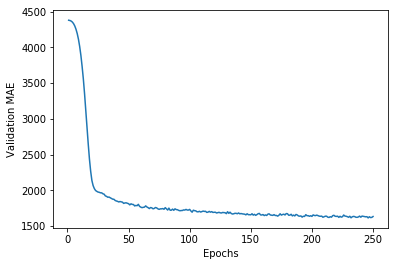

In [12]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

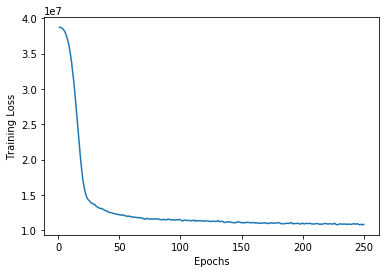

In [13]:
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

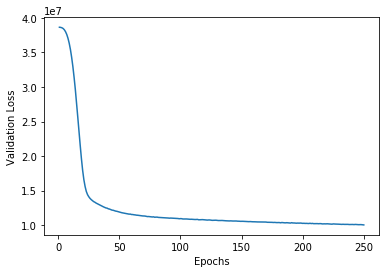

In [14]:
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
smooth_loss_history = smooth_curve(average_loss_history[10:])
smooth_val_loss_history = smooth_curve(average_val_loss_history[10:])

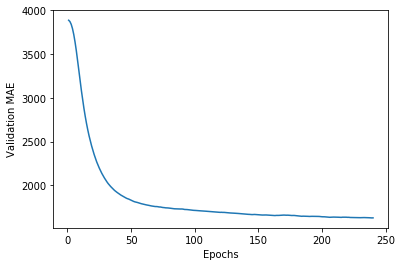

In [16]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

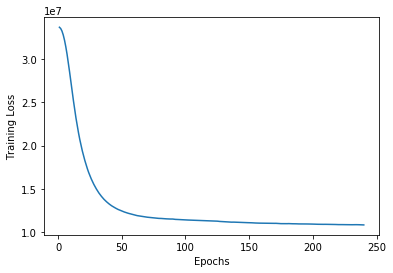

In [17]:
plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

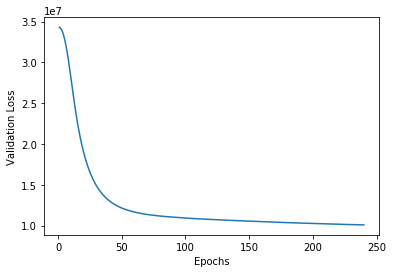

In [18]:
plt.plot(range(1, len(smooth_val_loss_history) + 1), smooth_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

In [19]:
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets, epochs=200, batch_size=120, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

200/200 [==============================] - 0s 437us/sample - loss: 25264966.4700 - mae: 1862.4988


In [20]:
test_mae_score

1862.4988

In [21]:
import random
rand_idx = random.sample(range(200), 1)
print('the predicted price of idx', rand_idx, 'is', model.predict(test_data[rand_idx]))
print('the actual price is of idx', rand_idx, 'is', test_targets[rand_idx])

the predicted price of idx [41] is [[4633.173]]
the actual price is of idx [41] is [2750.]


In [22]:
difference = []
for i in range(len(test_targets)):
    pred = model.predict(test_data[[i]])
    act = test_targets[i]
    diff = float(abs(act - pred))
    difference.append(diff)

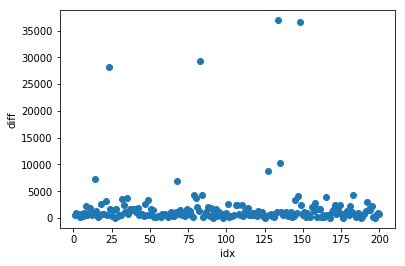

In [23]:
x = range(1, len(difference) + 1)
y = difference

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel('idx')
ax.set_ylabel('diff')


plt.show()

In [24]:
max_idx = np.argmax(difference)

In [25]:
test_targets[max_idx]

39900.0

In [26]:
model.predict(test_data[[max_idx]])

array([[2961.2983]], dtype=float32)

In [27]:
(test_data[[max_idx]]*std)+mean

array([[1.440e+03, 3.500e+03, 1.983e+03, 2.000e+00, 2.000e+00]])